## SARiSC Laboratorium

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from typing import List
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.model_selection import StratifiedKFold


    RRI (RR interval): Jest to odstęp czasu między kolejnymi skurczami serca, mierzony w milisekundach (ms). RRI jest miarą zmienności rytmu serca, która może być przydatna do oceny regulacji autonomicznej.

    RR-systolic: Odnosi się do ciśnienia skurczowego krwi, czyli najwyższego ciśnienia krwi w naczyniach krwionośnych, wyrażonego w milimetrach słupa rtęci (mmHg), które towarzyszy skurczowi serca.

    RR-diastolic: Odnosi się do ciśnienia rozkurczowego krwi, czyli najniższego ciśnienia krwi w naczyniach krwionośnych, wyrażonego w milimetrach słupa rtęci (mmHg), które występuje podczas rozkurczu serca.

    RR-mean: Odnosi się do ciśnienia średniego krwi, czyli średniego ciśnienia krwi w naczyniach krwionośnych w okresie cyklu sercowego, wyrażonego w milimetrach słupa rtęci (mmHg).

    IBI (Interbeat Interval): Jest to również odstęp czasu między kolejnymi skurczami serca, mierzony w milisekundach (ms). IBI jest również miarą zmienności rytmu serca i jest równoważne RRI.

In [3]:
class ColNames:
    time_ms = 'time[min]'
    rri_ms = 'rri[ms]'
    rr_systolic_mmHg = 'rr-systolic[mmHg]'
    rr_diastolic_mmHg = 'rr-diastolic[mmHg]'
    rr_mean_mmHg = 'rr-mean[mmHg]'
    rr_flags = 'rr-flags[]'
    ibi_ms = 'ibi[ms]'
    file_name = 'file name'
    sex = 'SEX [nominal codes: "1" woman; "2" man]'
    file = 'file'

class Paths:
    HRAecplorer = 'HRAexplorer/'
    Runs = HRAecplorer + 'Runs.xlsx'
    Spectral =  HRAecplorer + 'Spectral.xlsx'
    PoincrePlot = HRAecplorer + 'PoincrePlot.xlsx'
    HYPOL_RECORDINGS = 'HYPOL RECORDINGS/'
    HYPOL_Main = 'HYPOL clinical characteristics.xls'


class MyData:
    def __init__(self, target, value):
        self.target = target
        self.value = value

    def DFToVector(self):
        if isinstance(self.value, pd.DataFrame):
            return self.value.to_numpy().ravel()

    def DFModify(self):
        if isinstance(self.value, pd.DataFrame):
            columns_to_remove = [ColNames.time_ms, ColNames.rr_flags]
            self.value = self.value.drop(columns=columns_to_remove)


In [4]:
def limit_row(df_dict, limit):
    """
    Funkcja ograniczająca liczbę wierszy w każdym DataFrame w słowniku do określonej liczby.

    Parametry:
    - df_dict (dict): Słownik zawierający DataFrame'y.
    - limit (int): Maksymalna liczba wierszy, do której należy ograniczyć każdy DataFrame.

    Zwraca:
    - dict: Zaktualizowany słownik zawierający DataFrame'y z ograniczoną liczbą wierszy.
    """
    df_dict_res = {}
    for key in df_dict:
        df_temp = df_dict[key]
        df_dict_res[key] = df_temp.head(limit)

    return df_dict_res

def merge_v1(df_dict, df_labels, target) -> dict[str,MyData]:
    dic_res = {}
    for key in df_dict:
        dic_res[key] = MyData(df_labels.loc[df_labels[ColNames.file_name] == key].iloc[0][target], df_dict[key])
    return dic_res

def get_all_HRA_explorer_df():
    df_runs = pd.read_excel(Paths.Runs)
    df_poincre = pd.read_excel(Paths.PoincrePlot)
    df_spectral = pd.read_excel(Paths.Spectral)
    df = df_runs.merge(df_poincre, on=ColNames.file).merge(df_spectral, on=ColNames.file)
    return df
def get_df_main():
    df_main = pd.read_excel(Paths.HYPOL_Main)
    df_main.rename(columns={ColNames.file_name: ColNames.file}, inplace=True)
    return df_main


In [4]:


# Inicjalizacja pustego słownika
ekg_dict = {}

# Iteracja przez pliki w folderze
for filename in os.listdir(Paths.HYPOL_RECORDINGS):
    # Sprawdzenie, czy plik ma rozszerzenie .rea (załóżmy, że wszystkie pliki EKG mają to rozszerzenie)
    if filename.endswith('.rea'):
        # Pełna ścieżka do pliku
        file_path = os.path.join(Paths.HYPOL_RECORDINGS, filename)
        
        # Wczytanie pliku do DataFrame
        df_temp = pd.read_csv(file_path, delimiter='\t', header=0)
        
        # Dodanie do słownika, gdzie kluczem jest nazwa pliku, a wartością DataFrame
        ekg_dict[filename] = df_temp

In [5]:
df_main = get_df_main()

print(df_main.head())

        file  SEX [nominal codes: "1" woman; "2" man]  Age [years]   
0  ag016.rea                                        1           21  \
1  ag019.rea                                        1           26   
2  ag023.rea                                        1           24   
3  ag024.rea                                        2           24   
4  ag025.rea                                        2           24   

   BMI [kg/m2]  body Height [cm]  body WEIGHT [kg]  Pulse Rate [bpm]   
0        21.80               170                63                65  \
1        21.01               169                60                61   
2        20.32               166                56                66   
3        24.74               197                96                54   
4        22.49               170                65                55   

   Brachial SBP [mmHg]  Brachial DBP [mmHg]  Brachial MBP [mmHg]   
0                  115                   71                   84  \
1         

In [6]:
df_value = get_all_HRA_explorer_df()


   time[min]  rri[ms]  rr-flags[]  rr-systolic[mmHg]  rr-diastolic[mmHg]   
0   0.014469  868.125           0         195.693214           87.794417  \
1   0.028042  814.375           0         195.942458           91.336672   
2   0.041802  825.625           0         195.694063           88.056107   
3   0.056094  857.500           0         189.266213           82.930562   
4   0.070688  875.625           0         182.595409           82.675307   

   rr-mean[mmHg]  ibi[ms]  
0     113.298360  813.750  
1     114.135968  820.625  
2     112.332866  854.375  
3     107.729539  845.625  
4     106.704043  802.500  


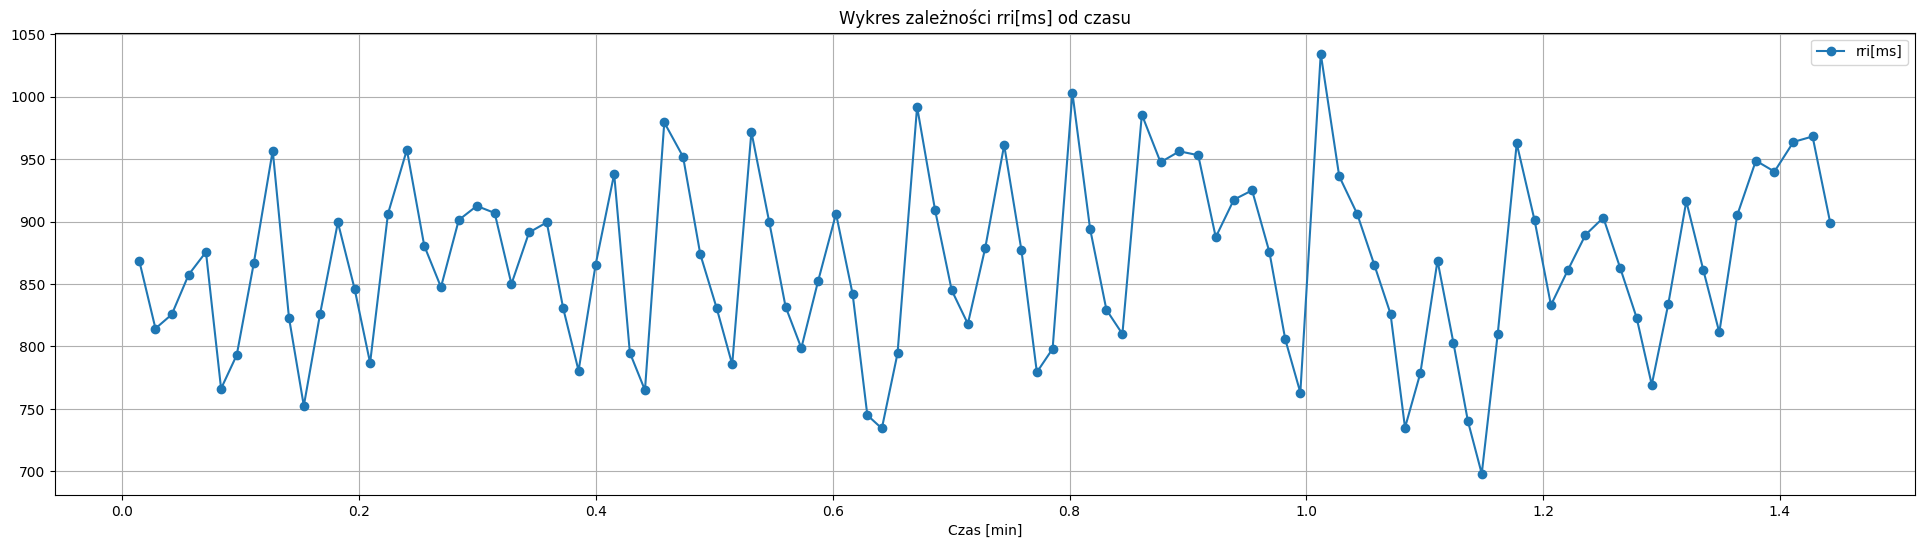

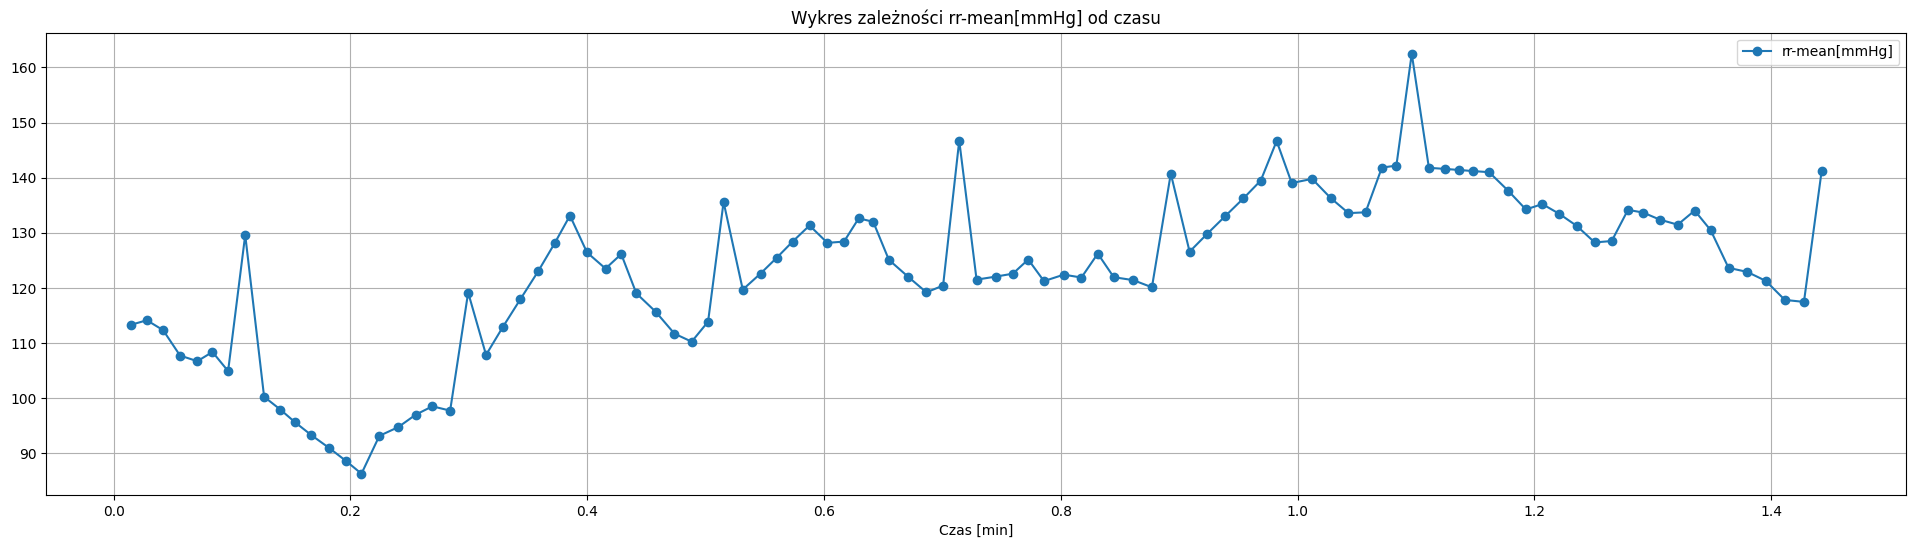

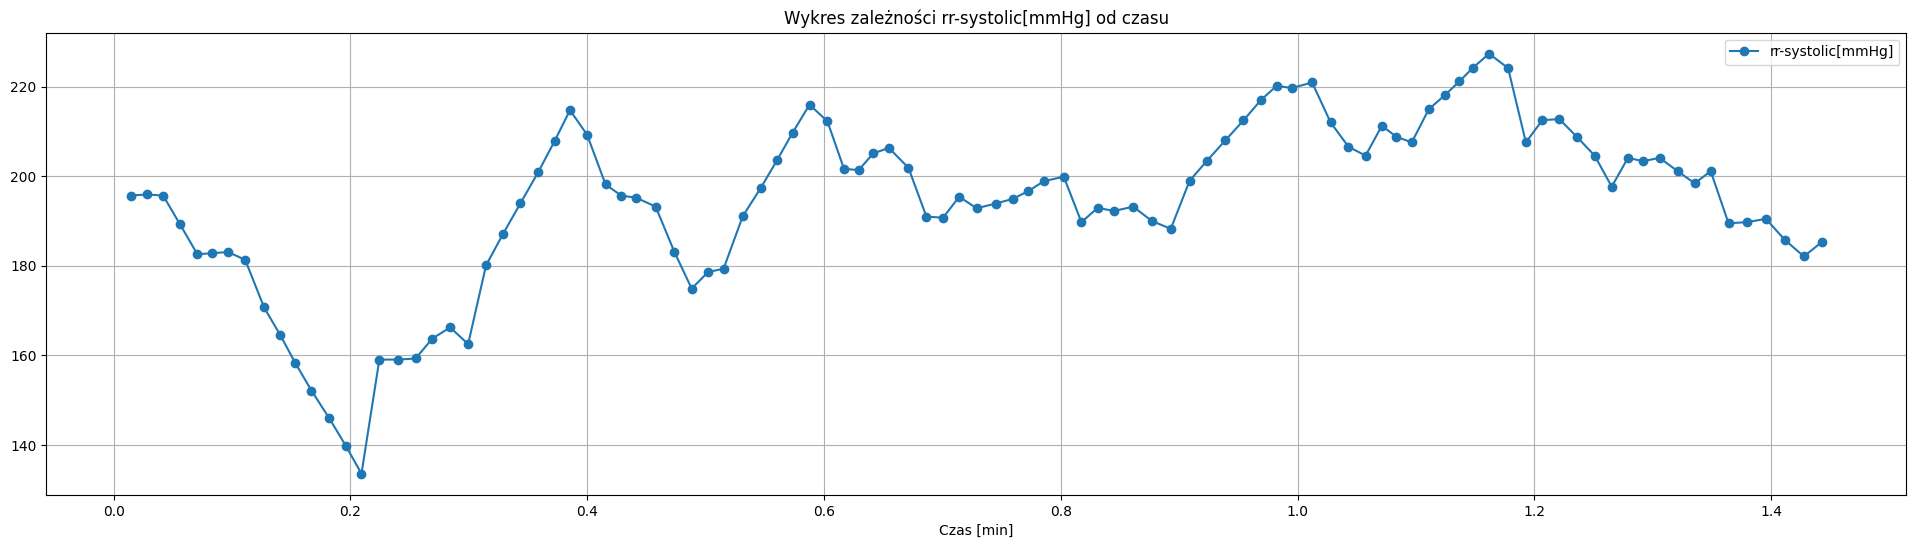

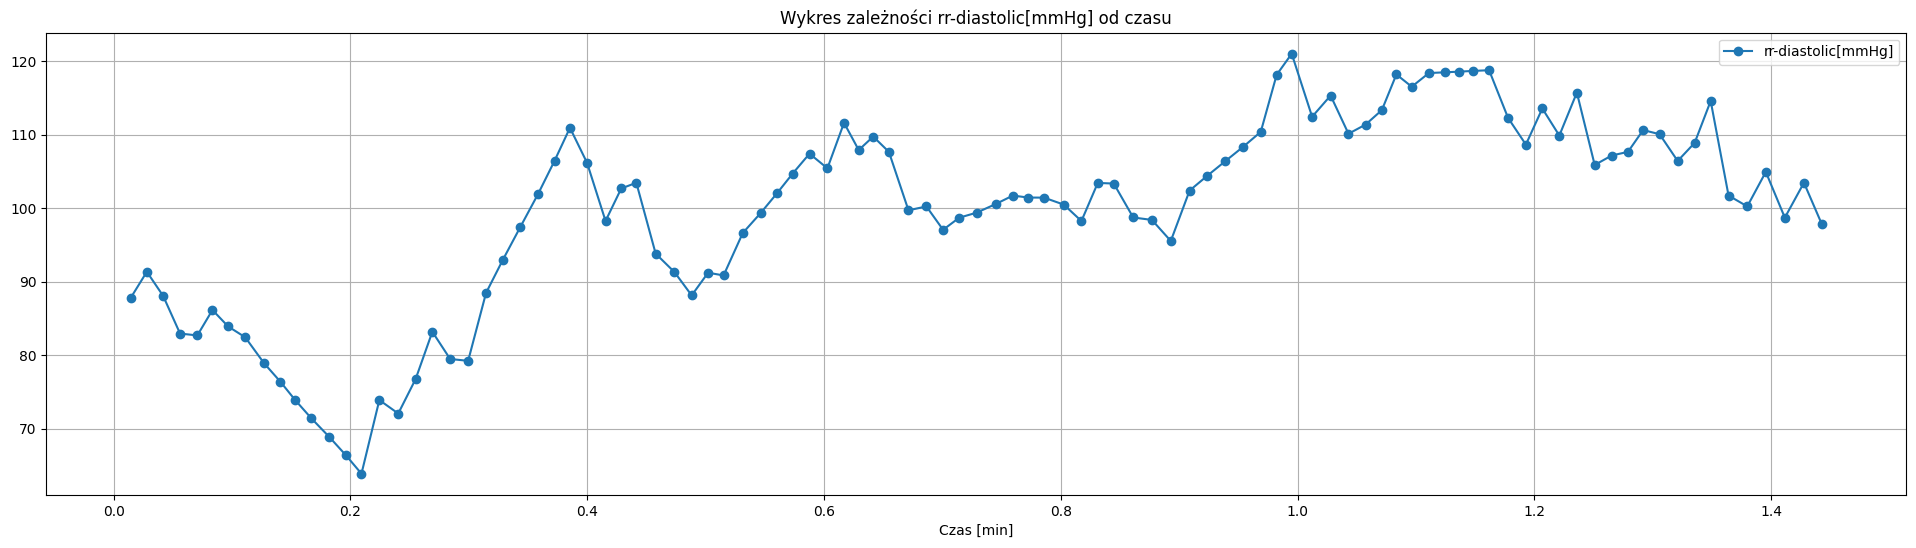

In [8]:
df_rea = pd.read_csv('HYPOL RECORDINGS/ag023.rea', delimiter='\t', header=0)
df_rea = df_rea.head(100)
print(df_rea.head())


plt.figure(figsize=(24, 6))
plt.plot(df_rea['time[min]'], df_rea[['rri[ms]']], marker='o', linestyle='-')
plt.title('Wykres zależności rri[ms] od czasu')
plt.xlabel('Czas [min]')
plt.grid(True)
plt.legend(['rri[ms]'])
plt.show()

plt.figure(figsize=(24, 6))
plt.plot(df_rea['time[min]'], df_rea[['rr-mean[mmHg]']], marker='o', linestyle='-')
plt.title('Wykres zależności rr-mean[mmHg] od czasu')
plt.xlabel('Czas [min]')
plt.grid(True)
plt.legend(['rr-mean[mmHg]'])
plt.show()

plt.figure(figsize=(24, 6))
plt.plot(df_rea['time[min]'], df_rea[ColNames.rr_systolic_mmHg], marker='o', linestyle='-')
plt.title(f'Wykres zależności {ColNames.rr_systolic_mmHg} od czasu')
plt.xlabel('Czas [min]')
plt.grid(True)
plt.legend([ColNames.rr_systolic_mmHg])
plt.show()

plt.figure(figsize=(24, 6))
plt.plot(df_rea['time[min]'], df_rea[ColNames.rr_diastolic_mmHg], marker='o', linestyle='-')
plt.title(f'Wykres zależności {ColNames.rr_diastolic_mmHg} od czasu')
plt.xlabel('Czas [min]')
plt.grid(True)
plt.legend([ColNames.rr_diastolic_mmHg])
plt.show()

In [6]:
ekg_dict_1000 = limit_row(ekg_dict, 700)
merged_dict = merge_v1(ekg_dict_1000, df_main, ColNames.sex)
for val in merged_dict.values():
    val.DFModify()

In [7]:
datas: List[MyData] = list(merged_dict.values())
targets = np.array([data.target for data in datas])
values = np.vstack([data.DFToVector() for data in datas])
train_targets, test_targets, train_values, test_values = train_test_split(targets, values, test_size=0.2, random_state=12, stratify=targets)

In [68]:
X_train = train_values  # wartości z danych treningowych
y_train = train_targets  # etykiety z danych treningowych

# Dane testowe
X_test = test_values  # wartości z danych testowych
y_test = test_targets  # etykiety z danych testowych

# Inicjalizacja klasyfikatora SVM
clf = svm.SVC(kernel='linear', C=0.1)

# Trenowanie modelu na danych treningowych
clf.fit(X_train, y_train)

# Testowanie modelu na danych testowych
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

# Obliczenie dokładności modelu
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Dokładność modelu SVM: {:.2f}%".format(train_accuracy * 100))
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu SVM: {:.2f}%".format(accuracy * 100))


clf_tree = DecisionTreeClassifier()

# Trenowanie modelu na danych treningowych
clf_tree.fit(X_train, y_train)

# Testowanie modelu na danych testowych
y_pred_tree = clf_tree.predict(X_test)
y_train_pred_tree = clf_tree.predict(X_train)

# Obliczenie dokładności modelu
train_accuracy_tree = accuracy_score(y_train, y_train_pred_tree)
print("Train Dokładność modelu Drzewa Decyzyjnego: {:.2f}%".format(train_accuracy_tree * 100))
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("Dokładność modelu Drzewa Decyzyjnego: {:.2f}%".format(accuracy_tree * 100))



clf_knn = KNeighborsClassifier(7)

# Trenowanie modelu na danych treningowych
clf_knn.fit(X_train, y_train)

# Testowanie modelu na danych testowych
y_pred_knn = clf_knn.predict(X_test)
y_train_pred_knn = clf_knn.predict(X_train)

# Obliczenie dokładności modelu
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print("Train Dokładność modelu k-najbliższych sąsiadów: {:.2f}%".format(train_accuracy_knn * 100))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Dokładność modelu k-najbliższych sąsiadów: {:.2f}%".format(accuracy_knn * 100))


Train Dokładność modelu SVM: 100.00%
Dokładność modelu SVM: 44.64%
Train Dokładność modelu Drzewa Decyzyjnego: 100.00%
Dokładność modelu Drzewa Decyzyjnego: 53.57%
Train Dokładność modelu k-najbliższych sąsiadów: 62.73%
Dokładność modelu k-najbliższych sąsiadów: 64.29%


In [39]:

clf = svm.SVC(kernel='linear') 
scores = cross_val_score(clf, values, targets, cv=10) 
for i, score in enumerate(scores):
    print("Wynik dla foldu", i+1, ":", score)
print("Średnia dokładność walidacji krzyżowej:", np.mean(scores))

Wynik dla foldu 1 : 0.75
Wynik dla foldu 2 : 0.6428571428571429
Wynik dla foldu 3 : 0.35714285714285715
Wynik dla foldu 4 : 0.35714285714285715
Wynik dla foldu 5 : 0.5714285714285714
Wynik dla foldu 6 : 0.5714285714285714
Wynik dla foldu 7 : 0.5925925925925926
Wynik dla foldu 8 : 0.48148148148148145
Wynik dla foldu 9 : 0.3333333333333333
Wynik dla foldu 10 : 0.5555555555555556
Średnia dokładność walidacji krzyżowej: 0.5212962962962963


In [42]:
X_train, X_test, y_train, y_test = train_test_split(values, targets, test_size=0.2, random_state=42)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
# Zastosowanie ADASYN do zwiększenia liczby danych 10-krotnie

target_ratio = {cls: count * 10 for cls, count in zip(unique_classes, class_counts)}

adasyn = ADASYN(sampling_strategy=target_ratio, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(X_train_resampled.shape)
# Trenowanie modelu klasyfikacji, na przykład klasyfikatora SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_resampled, y_train_resampled)

# Testowanie modelu na danych testowych
train_accuracy = clf.score(X_train_resampled, y_train_resampled)
print("Train Dokładność modelu SVM: {:.2f}%".format(train_accuracy * 100))
accuracy = clf.score(X_test, y_test)
print("Dokładność modelu SVM na danych testowych: {:.2f}%".format(accuracy * 100))

(2197, 3500)
Train Dokładność modelu SVM: 58.40%
Dokładność modelu SVM na danych testowych: 64.29%


In [9]:
# Utwórz obiekt klasy StratifiedKFold do przeprowadzenia walidacji krzyżowej
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Przeprowadź walidację krzyżową
train_accuracies = []
test_accuracies = []

for train_index, test_index in skf.split(values, targets):
    # Podział danych na zbiory treningowy i testowy
    X_train, X_test = values[train_index], values[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    # Obliczanie proporcji oversamplingu dla każdej klasy
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    target_ratio = {cls: count * 5 for cls, count in zip(unique_classes, class_counts)}
    
    # Zastosowanie ADASYN do zwiększenia liczby danych tylko dla zbioru treningowego
    adasyn = ADASYN(sampling_strategy=target_ratio, random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
    
    # Trenowanie modelu klasyfikacji, np. klasyfikatora SVM
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train_resampled, y_train_resampled)
    
    # Ocena dokładności na danych treningowych
    train_accuracy = clf.score(X_train_resampled, y_train_resampled)
    train_accuracies.append(train_accuracy)
    
    # Ocena dokładności na danych testowych
    test_accuracy = clf.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    print("Dokładność modelu SVM na danych treningowych: {:.2f}%".format(train_accuracy * 100))
    print("Dokładność modelu SVM na danych testowych: {:.2f}%".format(test_accuracy * 100))

# Obliczenie średniej dokładności dla danych treningowych i testowych
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

print("Średnia dokładność modelu SVM na danych treningowych: {:.2f}%".format(avg_train_accuracy * 100))
print("Średnia dokładność modelu SVM na danych testowych: {:.2f}%".format(avg_test_accuracy * 100))



Dokładność modelu SVM na danych treningowych: 59.95%
Dokładność modelu SVM na danych testowych: 57.14%
Dokładność modelu SVM na danych treningowych: 58.25%
Dokładność modelu SVM na danych testowych: 64.29%
Dokładność modelu SVM na danych treningowych: 56.00%
Dokładność modelu SVM na danych testowych: 57.14%
Dokładność modelu SVM na danych treningowych: 62.92%
Dokładność modelu SVM na danych testowych: 67.86%
Dokładność modelu SVM na danych treningowych: 59.58%
Dokładność modelu SVM na danych testowych: 57.14%
Dokładność modelu SVM na danych treningowych: 61.48%
Dokładność modelu SVM na danych testowych: 46.43%
Dokładność modelu SVM na danych treningowych: 55.23%
Dokładność modelu SVM na danych testowych: 55.56%
Dokładność modelu SVM na danych treningowych: 62.01%
Dokładność modelu SVM na danych testowych: 55.56%
Dokładność modelu SVM na danych treningowych: 56.73%
Dokładność modelu SVM na danych testowych: 48.15%
Dokładność modelu SVM na danych treningowych: 56.19%
Dokładność modelu SV

In [7]:

df = df_main[[ColNames.file, ColNames.sex]]
df = df.merge(df_value, on=ColNames.file)


In [8]:
np_values = df.drop(columns=[ColNames.file, ColNames.sex]).to_numpy()
np_targets = df[[ColNames.sex]].to_numpy().ravel()


In [9]:
print(df.info())
print(np_values.shape)
print(np_targets.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   file                                     276 non-null    object 
 1   SEX [nominal codes: "1" woman; "2" man]  276 non-null    int64  
 2   DR1                                      276 non-null    int64  
 3   DR2                                      276 non-null    int64  
 4   DR3                                      276 non-null    int64  
 5   DR4                                      276 non-null    int64  
 6   DR5                                      276 non-null    int64  
 7   DR6                                      276 non-null    int64  
 8   DR7                                      276 non-null    int64  
 9   DR8                                      276 non-null    int64  
 10  DR9                                      276 non-n

In [12]:
clf = svm.SVC(kernel='linear') 
scores = cross_val_score(clf, np_values, np_targets, cv=5) 
for i, score in enumerate(scores):
    print("Wynik dla foldu", i+1, ":", score)
print("Średnia dokładność walidacji krzyżowej:", np.mean(scores))

Wynik dla foldu 1 : 0.6428571428571429
Wynik dla foldu 2 : 0.5454545454545454
Wynik dla foldu 3 : 0.6909090909090909
Wynik dla foldu 4 : 0.5636363636363636
Wynik dla foldu 5 : 0.5272727272727272
Średnia dokładność walidacji krzyżowej: 0.594025974025974


In [26]:
def crossValid(splits: int, kernel: str, adasyn_multiply: int=5):
    skf = StratifiedKFold(n_splits=splits, random_state=42, shuffle=True)

    # Przeprowadź walidację krzyżową
    train_accuracies = []
    test_accuracies = []

    for train_index, test_index in skf.split(np_values, np_targets):
        # Podział danych na zbiory treningowy i testowy
        X_train, X_test = np_values[train_index], np_values[test_index]
        y_train, y_test = np_targets[train_index], np_targets[test_index]
        
        # Obliczanie proporcji oversamplingu dla każdej klasy
        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        count = np.max(class_counts) * adasyn_multiply
        target_ratio = {cls: count for cls in unique_classes}
        print(f'target_ratio: {target_ratio}')
        # Zastosowanie ADASYN do zwiększenia liczby danych tylko dla zbioru treningowego
        adasyn = ADASYN(sampling_strategy=target_ratio, random_state=42)
        X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
        
        # Trenowanie modelu klasyfikacji, np. klasyfikatora SVM
        clf = svm.SVC(kernel=kernel)
        clf.fit(X_train_resampled, y_train_resampled)
        
        # Ocena dokładności na danych treningowych
        train_accuracy = clf.score(X_train_resampled, y_train_resampled)
        train_accuracies.append(train_accuracy)
        
        # Ocena dokładności na danych testowych
        test_accuracy = clf.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        print("Dokładność modelu SVM na danych treningowych: {:.2f}%".format(train_accuracy * 100))
        print("Dokładność modelu SVM na danych testowych: {:.2f}%".format(test_accuracy * 100))

    # Obliczenie średniej dokładności dla danych treningowych i testowych
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)

    print("Średnia dokładność modelu SVM na danych treningowych: {:.2f}%".format(avg_train_accuracy * 100))
    print("Średnia dokładność modelu SVM na danych testowych: {:.2f}%".format(avg_test_accuracy * 100))

In [29]:
# Utwórz obiekt klasy StratifiedKFold do przeprowadzenia walidacji krzyżowej
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Przeprowadź walidację krzyżową
train_accuracies = []
test_accuracies = []

for train_index, test_index in skf.split(np_values, np_targets):
    # Podział danych na zbiory treningowy i testowy
    X_train, X_test = np_values[train_index], np_values[test_index]
    y_train, y_test = np_targets[train_index], np_targets[test_index]
    
    # Obliczanie proporcji oversamplingu dla każdej klasy
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    count = np.max(class_counts)
    target_ratio = {cls: count * 5 for cls in unique_classes}
    print(f'target_ratio: {target_ratio}')
    # Zastosowanie ADASYN do zwiększenia liczby danych tylko dla zbioru treningowego
    adasyn = SMOTE(sampling_strategy=target_ratio, random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
    
    # Trenowanie modelu klasyfikacji, np. klasyfikatora SVM
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train_resampled, y_train_resampled)
    
    # Ocena dokładności na danych treningowych
    train_accuracy = clf.score(X_train_resampled, y_train_resampled)
    train_accuracies.append(train_accuracy)
    
    # Ocena dokładności na danych testowych
    test_accuracy = clf.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    print("Dokładność modelu SVM na danych treningowych: {:.2f}%".format(train_accuracy * 100))
    print("Dokładność modelu SVM na danych testowych: {:.2f}%".format(test_accuracy * 100))

# Obliczenie średniej dokładności dla danych treningowych i testowych
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

print("Średnia dokładność modelu SVM na danych treningowych: {:.2f}%".format(avg_train_accuracy * 100))
print("Średnia dokładność modelu SVM na danych testowych: {:.2f}%".format(avg_test_accuracy * 100))


target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 79.47%
Dokładność modelu SVM na danych testowych: 57.14%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 77.65%
Dokładność modelu SVM na danych testowych: 78.57%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 79.02%
Dokładność modelu SVM na danych testowych: 50.00%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 74.70%
Dokładność modelu SVM na danych testowych: 64.29%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 75.68%
Dokładność modelu SVM na danych testowych: 71.43%
target_ratio: {1: 660, 2: 660}


In [17]:
crossValid(10, 'linear')

target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 76.15%
Dokładność modelu SVM na danych testowych: 53.57%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 73.07%
Dokładność modelu SVM na danych testowych: 75.00%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 75.15%
Dokładność modelu SVM na danych testowych: 57.14%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 73.41%
Dokładność modelu SVM na danych testowych: 60.71%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 70.28%
Dokładność modelu SVM na danych testowych: 78.57%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 75.23%
Dokładność modelu SVM na danych testowych: 60.71%
target_ratio: {1: 660, 2: 660}
Dokładność modelu SVM na danych treningowych: 75.06%
Dokładność modelu SVM na danych testowych: 48.15%
target_ratio: {1: 665, 2: 665}
Dokładność modelu SVM na danych

In [27]:
crossValid(5, 'rbf', adasyn_multiply=20)

target_ratio: {1: 2340, 2: 2340}
Dokładność modelu SVM na danych treningowych: 67.10%
Dokładność modelu SVM na danych testowych: 55.36%
target_ratio: {1: 2340, 2: 2340}
Dokładność modelu SVM na danych treningowych: 68.58%
Dokładność modelu SVM na danych testowych: 63.64%
target_ratio: {1: 2360, 2: 2360}
Dokładność modelu SVM na danych treningowych: 68.56%
Dokładność modelu SVM na danych testowych: 65.45%
target_ratio: {1: 2360, 2: 2360}
Dokładność modelu SVM na danych treningowych: 68.42%
Dokładność modelu SVM na danych testowych: 65.45%
target_ratio: {1: 2360, 2: 2360}
Dokładność modelu SVM na danych treningowych: 69.99%
Dokładność modelu SVM na danych testowych: 58.18%
Średnia dokładność modelu SVM na danych treningowych: 68.53%
Średnia dokładność modelu SVM na danych testowych: 61.62%
